Импорт библиотек:

In [ ]:
import numpy as np
from sys import maxsize as MAX_INT
from re import finditer, findall, sub
from random import randint
import pandas as pd
from imageio import imread, imwrite
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Создание дата фрейма для хранения результатов работ функций:

In [ ]:
test_results_df_data = []
for task_number in range(1, 6):
    for solution_number in range(1, 4):
        for test_number in range(1, 5):
            test_results_df_data.append({
                "Номер задачи": task_number,
                "Номер решения": solution_number,
                "Номер теста": test_number,
                "Результат тестирования": np.nan
            })

test_results_df = pd.DataFrame(data=test_results_df_data)

Декоратор для замера времени работы функции:

In [ ]:
def check_time(func: callable) -> callable:
    """
    Некоторые решения 4 задания выполняются 3 - 5 минут с этим декоратором.
    """

    def wrapper(*args, **kwargs):
        global test_results_df
        function_result = func(*args, **kwargs)
        less_tests = kwargs["less_tests"] if "less_tests" in kwargs else False
        if less_tests:
            time_test = %timeit -o -n 10 func(*args, **kwargs)
        else:
            time_test = %timeit -o -n 100 func(*args, **kwargs)
        milliseconds = float(time_test.average * 1e6)

        if "section" in kwargs and "subsection" in kwargs and "test_number" in kwargs:
            df_condition = (test_results_df["Номер задачи"] == kwargs["section"]) & \
                           (test_results_df["Номер решения"] == kwargs["subsection"]) & \
                           (test_results_df["Номер теста"] == kwargs["test_number"])

            test_results_df.loc[df_condition, "Результат тестирования"] = time_test
            test_results_df.loc[df_condition, "Результат тестирования в мкс"] = milliseconds

        return function_result

    return wrapper

# Максимум 5 баллов - по 1 баллу за задание

### 1. Подсчитать произведение ненулевых элементов на диагонали прямоугольной матрицы.
Для X = np.array([[1, 0, 1], [2, 0, 2], [3, 0, 3], [4, 4, 4]]) ответ 3.

1.1 Решение через цикл:

In [ ]:
task_tests = [np.array([[1, 0, 1], [2, 0, 2], [3, 0, 3], [4, 4, 4]]),
              np.random.randint(low=0, high=20, size=(randint(10, 30), randint(10, 30))),
              np.random.randint(low=0, high=100, size=(randint(5, 15), randint(5, 15))),
              np.random.randint(low=0, high=4, size=(randint(100, 300), randint(100, 300)))]

In [ ]:
@check_time
def multiplyDiagCycle(matrix: np.ndarray, **kwargs) -> int:
    if np.size(matrix.shape) != 2:
        raise Exception("Should be matrix given")

    result = 1.
    for i in range(len(matrix)):
        for j in range(len(matrix[0])):
            if (elem := matrix[i, j]) != 0 and i == j:
                result *= elem

    return result

for test_index, test in enumerate(task_tests):
    print(multiplyDiagCycle(test, section=1, subsection=1, test_number=test_index + 1))

9.58 µs ± 212 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.0
167 µs ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.8595287004505702e+17
22.9 µs ± 4.35 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1506897000.0
12.2 ms ± 5.01 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.860406034514964e+23


1.2 Векторизованный вариант:

In [ ]:
@check_time
def multiplyDiagNp(matrix: np.ndarray, **kwargs) -> int:
    if np.size(matrix.shape) != 2:
        raise Exception("Should be matrix given")

    return np.prod(np.diag(matrix)[np.diag(matrix) != 0], dtype=float)

for test_index, test in enumerate(task_tests):
    print(multiplyDiagNp(test, section=1, subsection=2, test_number=test_index + 1))

30.9 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.0
25.1 µs ± 4.93 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.8595287004505702e+17
22.5 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1506897000.0
23 µs ± 660 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.860406034514964e+23


1.3 Решение с помощью итератора:

In [ ]:
@check_time
def multiplyDiagIter(matrix: np.ndarray, **kwargs) -> int:
    if len(matrix.shape) != 2:
        raise Exception("Should be matrix given")

    result = 1.
    for index, value in np.ndenumerate(matrix):
        if index[0] == index[1] and value != 0:
            result *= value

    return result

for test_index, test in enumerate(task_tests):
    print(multiplyDiagIter(test, section=1, subsection=3, test_number=test_index + 1))

The slowest run took 4.38 times longer than the fastest. This could mean that an intermediate result is being cached.
22.8 µs ± 18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.0
372 µs ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.8595287004505702e+17
26.8 µs ± 5.12 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1506897000.0
13.7 ms ± 164 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.860406034514964e+23


### 2. Даны два вектора x и y. Проверить, задают ли они одно и то же мультимножество.
Для x = np.array([1, 2, 2, 4]), y = np.array([4, 2, 1, 2]) ответ True.

2.1 Решение через цикл:

In [ ]:
task_tests = [(np.array([1, 2, 2, 4]), np.array([4, 2, 1, 2])),

              (np.random.randint(low=0, high=10000, size=100),
               np.random.randint(low=0, high=10000, size=100)),

               (test3_first_vector := np.random.randint(low=0, high=100000, size=1000),
                np.random.permutation(test3_first_vector)),

                (test4_first_vector := np.random.randint(low=0, high=100000, size=10000),
                 np.random.permutation(test4_first_vector))]

In [ ]:
@check_time
def isMultiSetCycle(first_vector: np.ndarray, second_vector: np.ndarray, **kwargs) -> bool:
    entrance_dict = dict()
    for element in first_vector:
        entrance = entrance_dict.get(element, 0)
        entrance += 1
        entrance_dict[element] = entrance

    for element in second_vector:
        entrance = entrance_dict.get(element, 0)
        entrance -= 1
        entrance_dict[element] = entrance

    overlap_list = list(entrance_dict.values())

    return overlap_list.count(0) == len(overlap_list)

for test_index, test in enumerate(task_tests):
    print(isMultiSetCycle(test[0], test[1], section=2, subsection=1, test_number=test_index + 1))

11.3 µs ± 5.74 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
106 µs ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
False
1.08 ms ± 47.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
6.95 ms ± 2.11 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
True


2.2 Векторизованный вариант:

In [ ]:
@check_time
def isMultiSetNp(first_vector: np.ndarray, second_vector: np.ndarray, **kwargs) -> bool:
    return np.array_equal(np.sort(first_vector), np.sort(second_vector))

for test_index, test in enumerate(task_tests):
    print(isMultiSetNp(test[0], test[1], section=2, subsection=2, test_number=test_index + 1))

10.8 µs ± 2.11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
10.3 µs ± 244 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
False
94.4 µs ± 5.18 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
1.35 ms ± 23.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True


2.3 Альтернативное решение с помощью NumPy с использованием маски:

In [ ]:
@check_time
def isMultiSetNpAlt(first_vector: np.ndarray, second_vector: np.ndarray, **kwargs) -> bool:
    mask = np.isin(first_vector, second_vector)
    return np.all(mask)

for test_index, test in enumerate(task_tests):
    print(isMultiSetNpAlt(test[0], test[1], section=2, subsection=3, test_number=test_index + 1))

49.2 µs ± 13.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
81.8 µs ± 7.55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
False
242 µs ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True
157 µs ± 6.23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
True


### 3. Найти максимальный элемент в векторе x среди элементов, перед которыми стоит нулевой.
Для x = np.array([6, 2, 0, 3, 0, 0, 5, 7, 0]) ответ 5.

3.1 Решение через цикл:

In [ ]:
test1_array = np.array([6, 2, 0, 3, 0, 0, 5, 7, 0])

test2_array = np.hstack((np.zeros(20, dtype=int), np.random.randint(low=0, high=10000, size=100)))
np.random.shuffle(test2_array)

test3_array = np.hstack((np.zeros(200, dtype=int), np.random.randint(low=0, high=100000, size=1000)))
np.random.shuffle(test3_array)

test4_array = np.hstack((np.zeros(2000, dtype=int), np.random.randint(low=0, high=1000000, size=10000)))
np.random.shuffle(test4_array)

task_tests = [test1_array,
         test2_array,
         test3_array,
         test4_array]

In [ ]:
@check_time
def findMaxAfterZeroCycle(vector: np.ndarray, **kwargs) -> int:
    max_element = -MAX_INT
    found_flag = False
    for i in range(1, len(vector)):
        if vector[i - 1] == 0 and vector[i] > max_element:
            max_element = vector[i]
            found_flag = True
    if not found_flag:
        raise Exception("Cant find such element")

    return max_element

for test_index, test in enumerate(task_tests):
    print(findMaxAfterZeroCycle(test, section=3, subsection=1, test_number=test_index + 1))

The slowest run took 4.56 times longer than the fastest. This could mean that an intermediate result is being cached.
6.06 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5
25.8 µs ± 3.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9951
285 µs ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
99894
2.82 ms ± 76.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
999525


3.2 Векторизованный вариант:

In [ ]:
@check_time
def findMaxAfterZeroNp(vector: np.ndarray, **kwargs) -> int:
    zeros_mask = vector == 0
    after_zeros_mask = np.roll(zeros_mask, 1)
    after_zeros_mask[0] = False
    if np.size(candidate_vector := vector[after_zeros_mask]) == 0:
        raise Exception("0 elements after zero")
    else:
        return np.max(candidate_vector)

for test_index, test in enumerate(task_tests):
    print(findMaxAfterZeroNp(test, section=3, subsection=2, test_number=test_index + 1))

20.8 µs ± 588 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
5
41.8 µs ± 8.13 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9951
24.5 µs ± 663 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
99894
82.1 µs ± 2.77 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
999525


3.3 Решение с помощью регулярного выражения:

In [ ]:
@check_time
def findMaxAfterZeroRegExp(vector: np.ndarray, **kwargs) -> int:
    vector_str = 'x'.join(map(str, vector))
    if vector_str.find("x0x0x") != -1: prevented_max = 0 # Учитываем "0"
    vector_str = sub(r"(x0(?=x0x))+", "", vector_str) # Удаляем все случаи, в которых встречаются последовательности "0"

    vector_str = vector_str.replace("x0x", "xy") # В данном случае y - начало, x - конец нужных нам чисел
    matches = findall(r'y[0-9]*?x', vector_str) # Находим все числа, удовлетворяющие условия (y<число>x)

    results = [int(match[1:-1]) for match in matches]

    return np.max(np.max(results), 0)

for test_index, test in enumerate(task_tests):
    print(findMaxAfterZeroRegExp(test, section=3, subsection=3, test_number=test_index + 1))

31.9 µs ± 11 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5
85.5 µs ± 16 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
9951
684 µs ± 62.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
99894
8.78 ms ± 2.39 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
999525


### 4. Дан трёхмерный массив, содержащий изображение, размера (height, width, numChannels), а также вектор длины numChannels. Сложить каналы изображения с указанными весами, и вернуть результат в виде матрицы размера (height, width). Считать реальное изображение можно при помощи функции scipy.misc.imread (если изображение не в формате png, установите пакет pillow: conda install pillow). Преобразуйте цветное изображение в оттенки серого, использовав коэффициенты np.array([0.299, 0.587, 0.114]).

4.1 Решение через цикл:

In [ ]:
test1_image = imread("test1_image.png") # 640x360
test2_image = imread("test2_image.png") # 1200x630
test3_image = imread("test3_image.png") # 2560x2048
image_tests = [test1_image,
               test2_image,
               test3_image]
COEFFICIENTS = np.array([0.299, 0.587, 0.114])

<ipython-input-43-bfc6e61d9f21>:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test1_image = imread("test1_image.png") # 640x360
<ipython-input-43-bfc6e61d9f21>:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test2_image = imread("test2_image.png") # 1200x630
<ipython-input-43-bfc6e61d9f21>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  test3_image = imread("test3_image.png") #

In [ ]:
@check_time
def convertToBlackWhiteCycle(source_image, coefficients, **kwargs):
    image = source_image[:, :, :3]
    result_matrix = np.zeros((image.shape[0], image.shape[1]))
    for height_index in range(image.shape[0]):
        for width_index in range(image.shape[1]):
            pixel = np.dot(image[height_index, width_index], coefficients)
            result_matrix[height_index][width_index] = pixel

    imwrite(f"test{kwargs['test_number']}_result_image{kwargs['subsection']}.png",
            mod_im := result_matrix.astype(np.uint8))

    return mod_im

for test_index, image_test in enumerate(image_tests):
    convertToBlackWhiteCycle(image_test,
                             COEFFICIENTS,
                             section=4,
                             subsection=1,
                             test_number=test_index + 1,
                             less_tests=True)

572 ms ± 48.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.84 s ± 102 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
11.9 s ± 252 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Результат всех функций пукнта 4 аналогичен и приведен ниже:

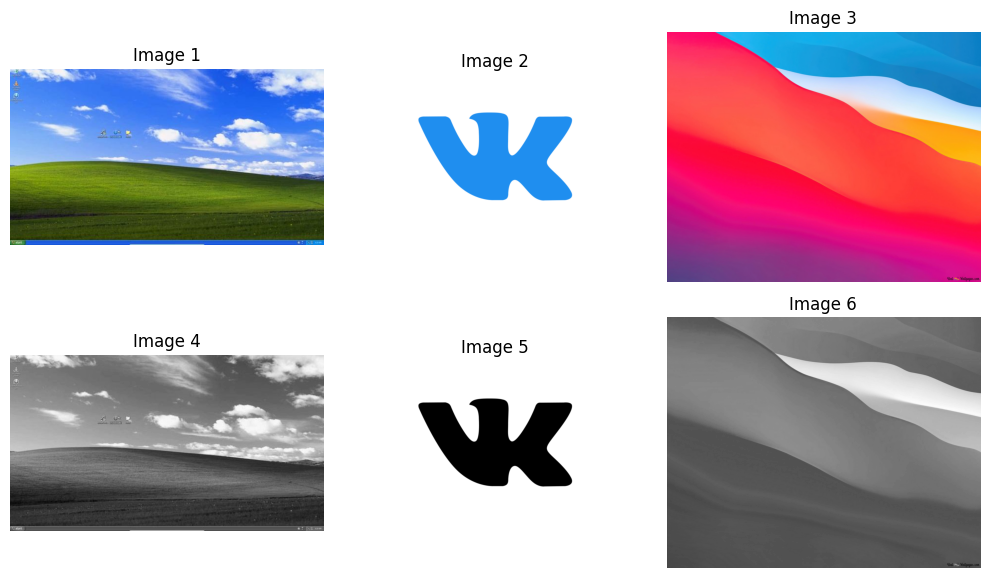

In [ ]:
test_image1 = mpimg.imread("test1_image.png", format="jpeg") # Данное изображение было скачено как jpeg
test_image2 = mpimg.imread("test2_image.png")
test_image3 = mpimg.imread("test3_image.png", format="jpeg")

result_image1 = mpimg.imread("test1_result_image1.png")
result_image2 = mpimg.imread("test2_result_image1.png")
result_image3 = mpimg.imread("test3_result_image1.png")

images = [test_image1, test_image2, test_image3,
          result_image1, result_image2, result_image3]

fig, axis = plt.subplots(2, 3, figsize=(10, 6))

for i, axis in enumerate(axis.flat):
    axis.imshow(images[i], cmap="gray")
    axis.axis("off")
    axis.set_title(f"Image {i + 1}")

plt.tight_layout()
plt.show()

4.2 Векторизованный вариант:

In [ ]:
@check_time
def convertToBlackWhiteNp(source_image, coefficients, **kwargs):
    image = source_image[:, :, :3]

    result_matrix = np.dot(image, coefficients).astype(np.uint8)

    imwrite(f"test{kwargs['test_number']}_result_image{kwargs['subsection']}.png",
            result_matrix)

    return result_matrix

for test_index, image_test in enumerate(image_tests):
    convertToBlackWhiteNp(image_test,
                          COEFFICIENTS,
                          section=4,
                          subsection=2,
                          test_number=test_index + 1,
                          less_tests=True)

47.4 ms ± 635 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
34.6 ms ± 707 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
390 ms ± 41.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


4.3 Альтернативное решение:
Представлена функция конвертации RGB-массива в скаляр в соответствии с коэффициентами.
Эта функция применяется для каждого элемента вдоль оси 3-го измерения массива.

In [ ]:
@check_time
def convertToBlackWhiteNp(source_image, coefficients, **kwargs):
    image = source_image[:, :, :3]

    def convertRow(row):
        return np.dot(row, coefficients)

    result_matrix = np.apply_along_axis(convertRow, axis=2, arr=image).astype(np.uint8)

    imwrite(f"test{kwargs['test_number']}_result_image{kwargs['subsection']}.png",
            result_matrix)

    return result_matrix

for test_index, image_test in enumerate(image_tests):
    convertToBlackWhiteNp(image_test,
                          COEFFICIENTS,
                          section=4,
                          subsection=3,
                          test_number=test_index + 1,
                          less_tests=True)

864 ms ± 41.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.73 s ± 46.6 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
19.1 s ± 40.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### 5. Реализовать кодирование длин серий (Run-length encoding). Дан вектор x. Необходимо вернуть кортеж из двух векторов одинаковой длины. Первый содержит числа, а второй - сколько раз их нужно повторить.
Пример: x = np.array([2, 2, 2, 3, 3, 3, 5, 2, 2]). Ответ: (np.array([2, 3, 5, 2]), np.array([3, 3, 1, 2])).

5.1 Решение через цикл:

In [ ]:
test1_array = np.array([2, 2, 2, 3, 3, 3, 5, 2, 2])

test2_samples = np.random.randint(low=0, high=10000, size=30)
test2_frequencies = np.random.randint(low=1, high=8, size=np.size(test2_samples))
test2_array = np.repeat(test2_samples, test2_frequencies)

test3_samples = np.random.randint(low=0, high=100000, size=300)
test3_frequencies = np.random.randint(low=1, high=80, size=np.size(test3_samples))
test3_array = np.repeat(test3_samples, test3_frequencies)

test4_samples = np.random.randint(low=0, high=1000000, size=3000)
test4_frequencies = np.random.randint(low=1, high=80, size=np.size(test4_samples))
test4_array = np.repeat(test4_samples, test4_frequencies)

task_tests = [test1_array,
              test2_array,
              test3_array,
              test4_array]

In [ ]:
@check_time
def runLengthEncodeCycle(source_vector: np.ndarray, **kwargs) -> tuple[list[int], list[int]]:
    vector = np.append(source_vector, 'x') # При добавлении элемента создается копия массива
    elements = []
    frequency = []
    current_element = vector[0]
    current_element_count = 0

    for element in vector:
        if element == current_element:
            current_element_count += 1
        else:
            elements.append(int(current_element))
            frequency.append(current_element_count)
            current_element = element
            current_element_count = 1

    return (elements, frequency)

for test_index, test in enumerate(task_tests):
    print(runLengthEncodeCycle(test, section=5, subsection=1, test_number=test_index + 1))

14.2 µs ± 1.94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
([2, 3, 5, 2], [3, 3, 1, 2])
79.7 µs ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
([9900, 627, 1687, 8873, 8458, 1929, 354, 7465, 5517, 1042, 6606, 4772, 9470, 5861, 5620, 1386, 5306, 7204, 3792, 3099, 241, 8183, 8159, 5021, 539, 4429, 3885, 9664, 168, 9997], [2, 1, 4, 4, 5, 3, 1, 7, 1, 1, 1, 4, 5, 4, 7, 3, 7, 3, 2, 4, 1, 2, 5, 2, 7, 6, 5, 4, 3, 3])
7.19 ms ± 126 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
([38474, 65169, 72938, 67726, 70269, 28029, 57316, 30146, 80658, 91301, 87576, 5781, 81256, 11670, 45829, 43811, 71202, 29733, 53102, 65456, 93843, 34871, 81606, 90768, 71399, 26856, 91908, 40762, 47628, 64066, 31578, 53097, 45082, 85331, 96967, 29320, 15374, 80752, 12501, 44414, 33299, 99829, 3203, 40823, 25733, 1978, 82523, 92462, 21934, 21213, 22146, 17036, 11719, 28090, 54851, 99459, 79500, 40515, 14823, 21682, 97722, 71885, 93862, 77584, 52673, 60946, 7070, 80494, 22142, 66402

5.2 Векторизованный вариант:

In [ ]:
@check_time
def runLengthEncodeNp(vector: np.ndarray, **kwargs) -> tuple[list[int], list[int]]:
    split_indices = np.where(np.diff(vector) != 0)[0] + 1
    partition = np.split(vector, split_indices)
    partition_tuples = list(map(lambda part: (part[0], np.size(part)), partition))
    values, lengths = zip(*partition_tuples)
    result = (list(values), list(lengths))
    return result

for test_index, test in enumerate(task_tests):
    print(runLengthEncodeNp(test, section=5, subsection=2, test_number=test_index + 1))

30.6 µs ± 11.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
([2, 3, 5, 2], [3, 3, 1, 2])
73.7 µs ± 16.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
([9900, 627, 1687, 8873, 8458, 1929, 354, 7465, 5517, 1042, 6606, 4772, 9470, 5861, 5620, 1386, 5306, 7204, 3792, 3099, 241, 8183, 8159, 5021, 539, 4429, 3885, 9664, 168, 9997], [2, 1, 4, 4, 5, 3, 1, 7, 1, 1, 1, 4, 5, 4, 7, 3, 7, 3, 2, 4, 1, 2, 5, 2, 7, 6, 5, 4, 3, 3])
614 µs ± 79 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
([38474, 65169, 72938, 67726, 70269, 28029, 57316, 30146, 80658, 91301, 87576, 5781, 81256, 11670, 45829, 43811, 71202, 29733, 53102, 65456, 93843, 34871, 81606, 90768, 71399, 26856, 91908, 40762, 47628, 64066, 31578, 53097, 45082, 85331, 96967, 29320, 15374, 80752, 12501, 44414, 33299, 99829, 3203, 40823, 25733, 1978, 82523, 92462, 21934, 21213, 22146, 17036, 11719, 28090, 54851, 99459, 79500, 40515, 14823, 21682, 97722, 71885, 93862, 77584, 52673, 60946, 7070, 80494, 22142, 66402, 

5.3 Частично векторизованное решение:

In [ ]:
@check_time
def runLengthEncodeSemiNp(vector: np.ndarray, **kwargs) -> tuple[list[int], list[int]]:
    split_indices = np.where(np.diff(vector) != 0)[0] + 1
    partition = np.split(vector, split_indices)
    out = ([], [])
    for part in partition:
        out[0].append(part[0])
        out[1].append(np.size(part))

    return out

for test_index, test in enumerate(task_tests):
    print(runLengthEncodeSemiNp(test, section=5, subsection=3, test_number=test_index + 1))

30.9 µs ± 8.29 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
([2, 3, 5, 2], [3, 3, 1, 2])
71.3 µs ± 6.14 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
([9900, 627, 1687, 8873, 8458, 1929, 354, 7465, 5517, 1042, 6606, 4772, 9470, 5861, 5620, 1386, 5306, 7204, 3792, 3099, 241, 8183, 8159, 5021, 539, 4429, 3885, 9664, 168, 9997], [2, 1, 4, 4, 5, 3, 1, 7, 1, 1, 1, 4, 5, 4, 7, 3, 7, 3, 2, 4, 1, 2, 5, 2, 7, 6, 5, 4, 3, 3])
620 µs ± 51.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
([38474, 65169, 72938, 67726, 70269, 28029, 57316, 30146, 80658, 91301, 87576, 5781, 81256, 11670, 45829, 43811, 71202, 29733, 53102, 65456, 93843, 34871, 81606, 90768, 71399, 26856, 91908, 40762, 47628, 64066, 31578, 53097, 45082, 85331, 96967, 29320, 15374, 80752, 12501, 44414, 33299, 99829, 3203, 40823, 25733, 1978, 82523, 92462, 21934, 21213, 22146, 17036, 11719, 28090, 54851, 99459, 79500, 40515, 14823, 21682, 97722, 71885, 93862, 77584, 52673, 60946, 7070, 80494, 22142, 66402

### Анализ результатов работы функций:

Дата фрейм с результатами всех измерений:

In [ ]:
test_results_df

,Номер задачи,Номер решения,Номер теста,Результат тестирования,Результат тестирования в мкс
0,1,1,1,9.58 µs ± 212 ns per loop (mean ± std. dev. of...,9.584859e+00
1,1,1,2,167 µs ± 16.7 µs per loop (mean ± std. dev. of...,1.665632e+02
2,1,1,3,22.9 µs ± 4.35 µs per loop (mean ± std. dev. o...,2.290268e+01
3,1,1,4,12.2 ms ± 5.01 ms per loop (mean ± std. dev. o...,1.216818e+04
4,1,2,1,30.9 µs ± 11.5 µs per loop (mean ± std. dev. o...,3.085571e+01
5,1,2,2,25.1 µs ± 4.93 µs per loop (mean ± std. dev. o...,2.512500e+01
6,1,2,3,22.5 µs ± 1.27 µs per loop (mean ± std. dev. o...,2.245285e+01
7,1,2,4,23 µs ± 660 ns per loop (mean ± std. dev. of 7...,2.303167e+01
8,1,3,1,22.8 µs ± 18 µs per loop (mean ± std. dev. of ...,2.275885e+01
9,1,3,2,372 µs ± 102 µs per loop (mean ± std. dev. of ...,3.721062e+02


Эффективность различных решений по времени:

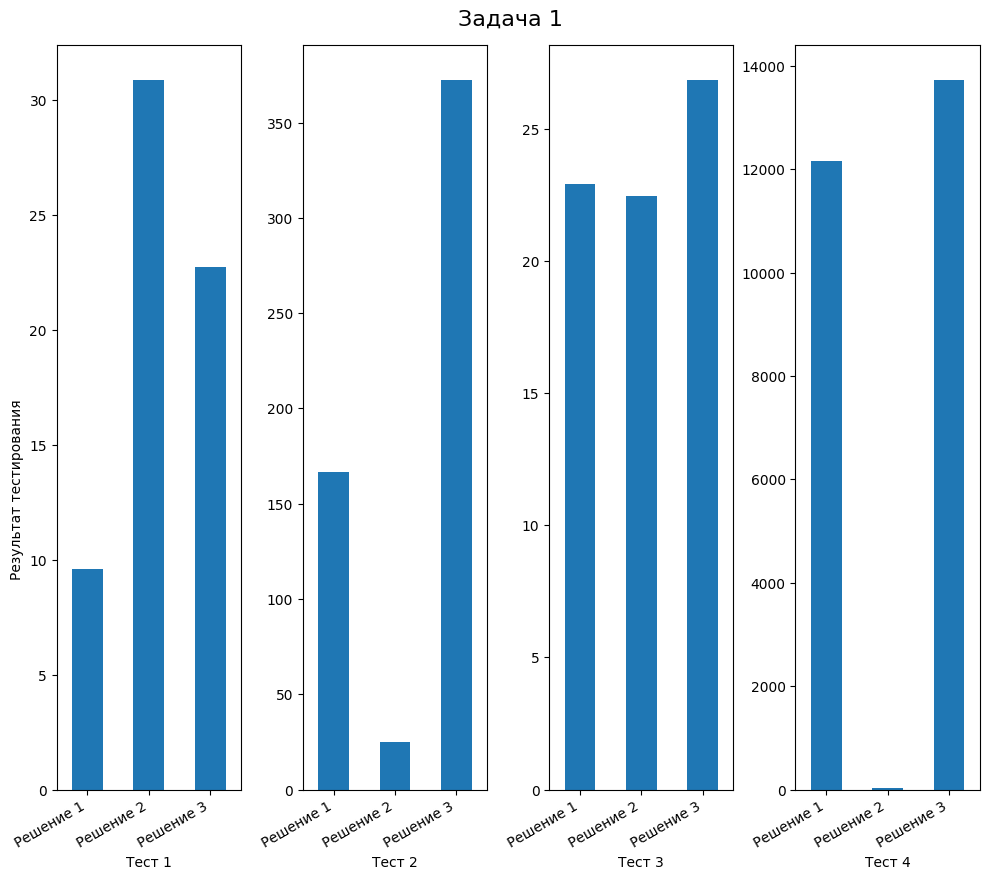

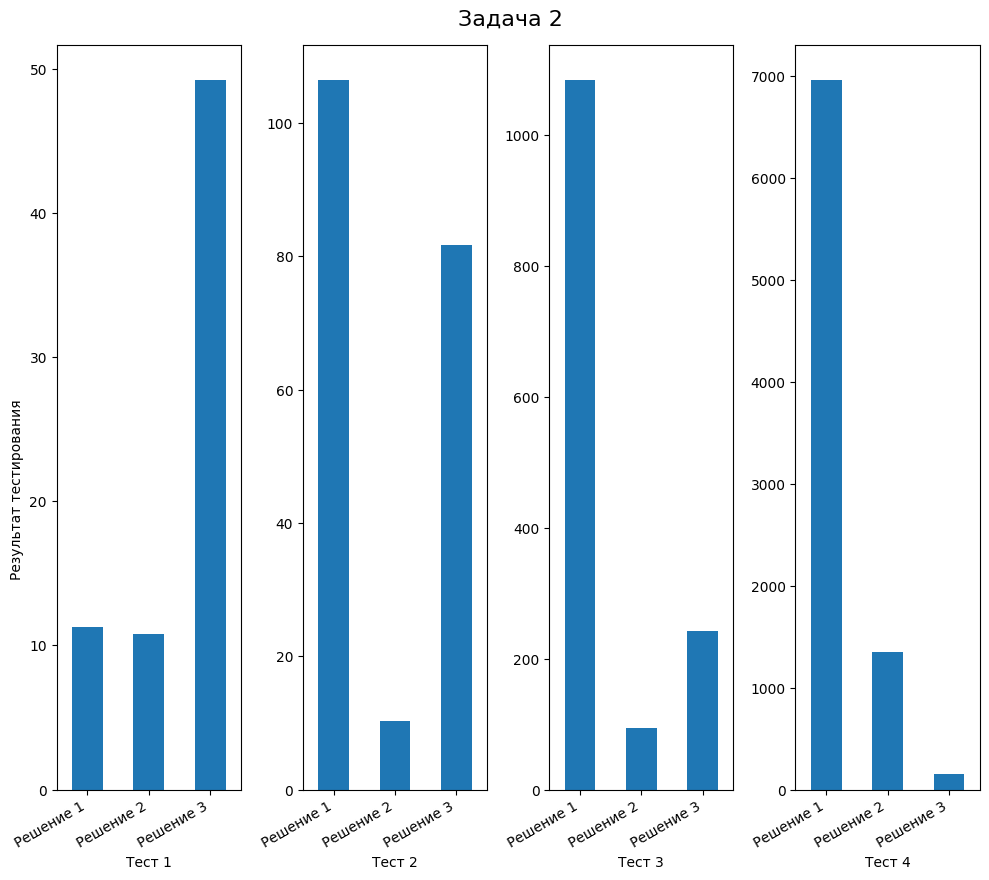

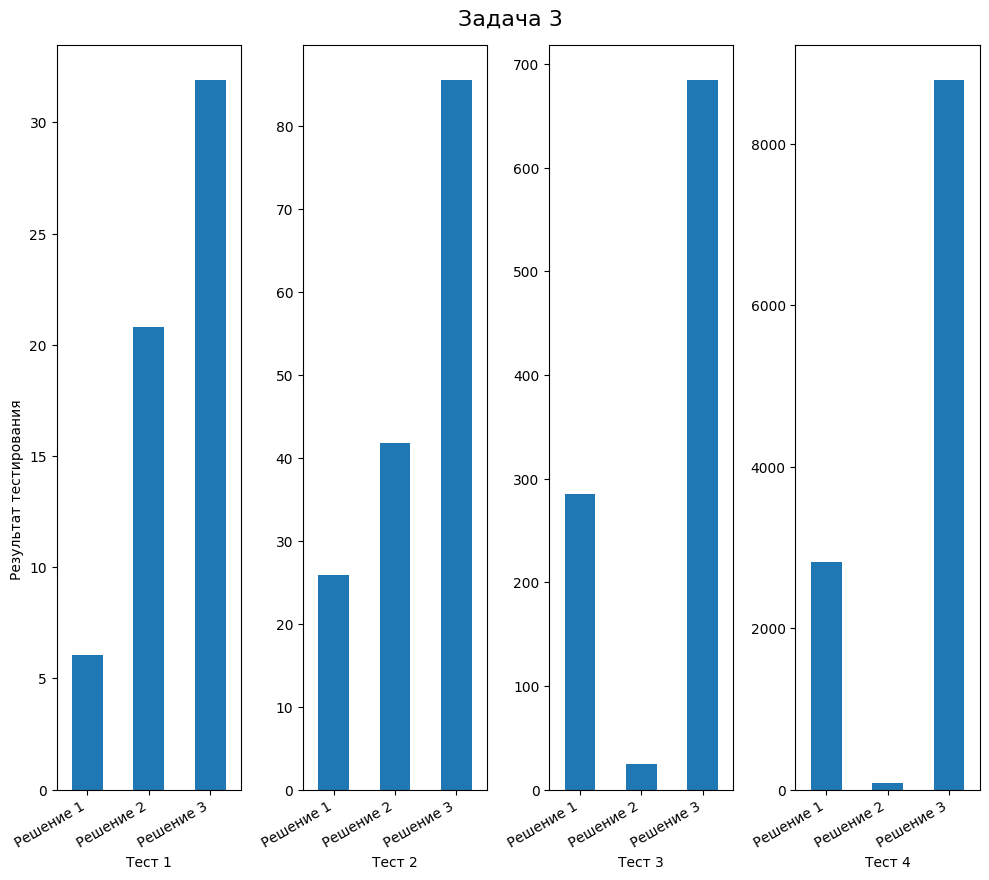

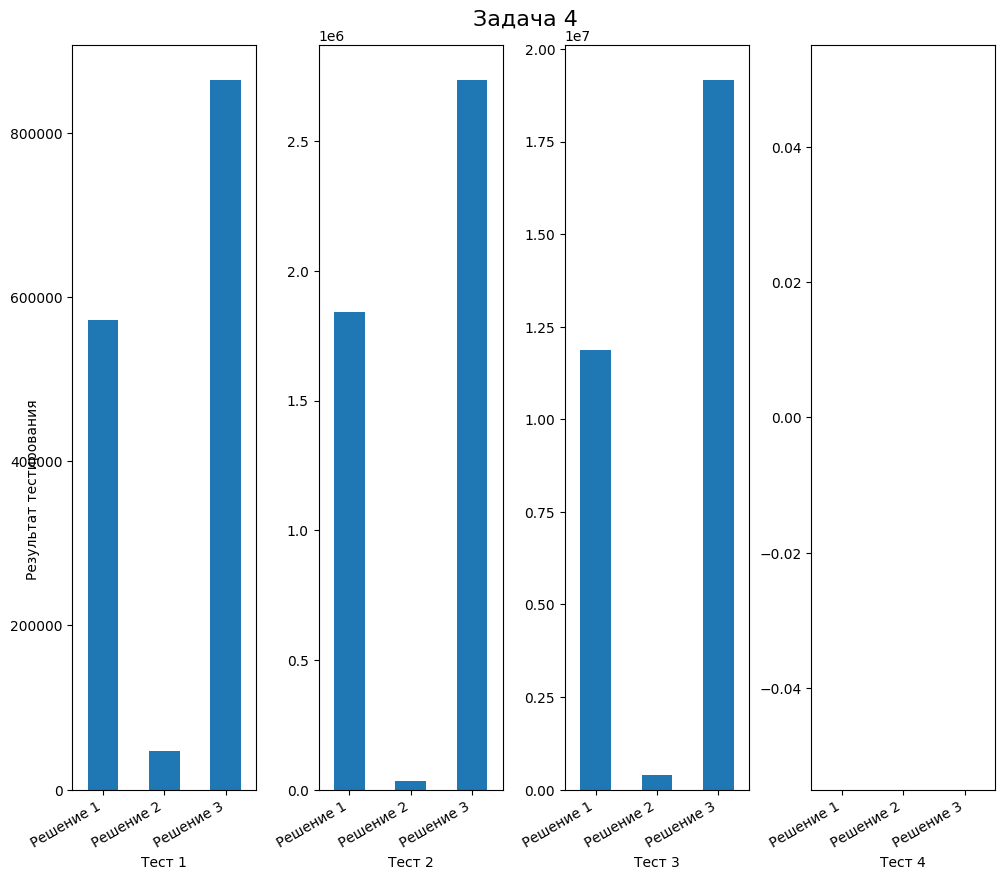

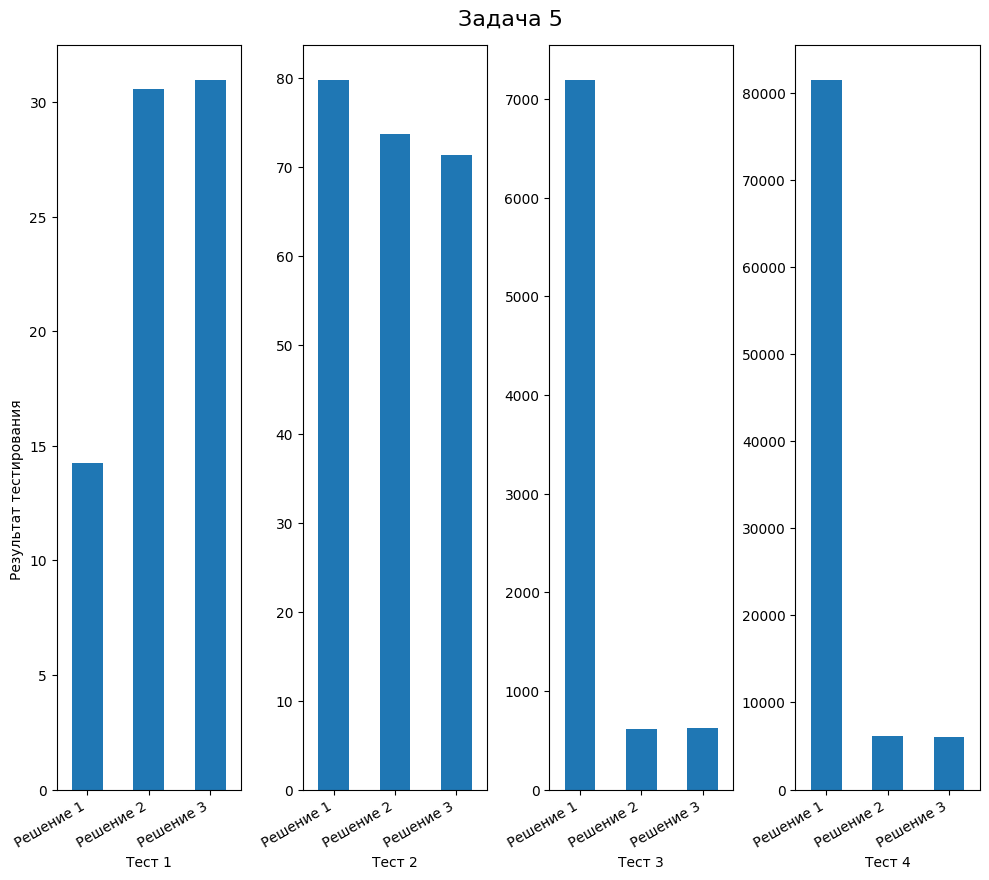

In [ ]:
for task_number in range(1, 6):
    fig, axs = plt.subplots(1, 4, figsize=(10, 10))
    fig.suptitle(f"Задача {task_number}", fontsize=16)
    fig.tight_layout()
    xticklabels = ["Решение 1", "Решение 2", "Решение 3"]
    fig.text(0, 0.5, "Результат тестирования", va="center", rotation="vertical")

    for test_number in range(1, 5):
        selection_condition = (test_results_df["Номер задачи"] == task_number) \
            & (test_results_df["Номер теста"] == test_number)
        task_df = test_results_df[selection_condition]["Результат тестирования в мкс"]

        task_df.plot(kind="bar", ax=axs[test_number - 1])
        axs[test_number - 1].set_xticklabels(xticklabels)
        axs[test_number - 1].set_xlabel(f"Тест {test_number}")
        axs[test_number - 1].xaxis_date()
        fig.autofmt_xdate()

Проанализируем результаты замеров:

**Для задачи 1** представлено 3 варианта решения: с помощью цикла, векторизованный, с помощью итератора. Решения через цикл и через итератор по времени примерно равны (На больших данных вариант через enumerator немного проигрывает) и имеют более быструю скорость работы на маленьких матрицах. На матрицах большей размерности векторизованный вариант имеет колоссальное преимущество во времени выполнения.
<br/>
**Для задачи 2** представлено 3 варианта решения: с помощью цикла, векторизованный с использованием сортировок, векторизованный с использованием маски. Решения через цикл выигрывает на очень маленьких данных. На данных среднего размера самым эффективным оказался векторизованный вариант через сортировки. Но на больших данных что цикл, что вариант с сортировками намного медленнее варианта с маской. Также интересное замечание, что вариант с маской имеет очень близкие результаты для всех тестов.
<br/>
**Для задачи 3** представлено 3 варианта решения: с помощью цикла, векторизованный, с помощью регулярных выражений. На маленьких данных, как и ожидалось, цикл работает быстрее. Вариант с использованием регулярок сильно проигрывает почти во всех тестах, т.к. для его работы необходимо совершить большое количество преобразований строк. На средних и больших данных векторизованный вариант работает намного быстрее предыдущих решений.
<br/>
**Для задачи 4** представлено 3 варианта решения: с помощью цикла, векторизованный, векторизованный с использованием np.dot для каждого элемента соответствующего измерения. Третье решение оказалось самым медленным на всех тестах, это связано с тем, что в процессе выполнения функции происходит большое количество вызовов функции convertRow. Векторизованное решение имеет большой отрыв по времени относительно других решений. Функция с циклом оказалось эффективнее третьего решения, но все равно сильно проигрывает векторизованному.
<br/>
**Для задачи 5** представлено 3 варианта решения: с помощью цикла, векторизованный, частично векторизованный. Векторизованное и частично векторизованное решения показали примерно одинаковые результаты. Оба решения работают намного быстрее решения с циклом на средних и больших данных (на больших данных разница огромная). На маленьких данных частично векторизованное решение и решение с циклом работют примерно одинаково. Векторизованное решение является самым простым в понимании и написании и в то же время самым быстрым (причем разница большая). Решение с циклом, как и предполагалось, работает медленнее по сравнению с векторизованным решением.

### Вывод

Для всех задач можно сделать один общий вывод. Векторизованные решения с использоанием NumPy работают намного быстрее классических, написанных с помощью циклов. Это связано с тем, что функции NumPy написаны на компилируемых языках: C, Fortran, и работают с элементами массивов одновременно.

##### Замечание. Можно считать, что все указанные объекты непустые (к примеру, в задаче №1 на диагонали матрицы есть ненулевые элементы).
Полезные функции NumPy: np.zeros, np.ones, np.diag, np.eye, np.arange, np.linspace, np.meshgrid,
np.random.random, np.random.randint, np.shape, np.reshape, np.transpose, np.any, np.all, np.nonzero, np.where,
np.sum, np.cumsum, np.prod, np.diff, np.min, np.max, np.minimum, np.maximum, np.argmin, np.argmax, np.unique,
np.sort, np.argsort, np.bincount, np.ravel, np.newaxis, np.dot, np.linalg.inv, np.linalg.solve.
Многие из этих функций можно использовать так: x.argmin().

# Для каждой из задач:
(a) Написать на Python + NumPy несколько вариантов кода различной эффективности. Должно быть не
менее трёх вариантов, в том числе как минимум один полностью векторизованный вариант (без циклов), и один
вариант без векторизации (с циклами). Третий вариант решения — на ваше усмотрение, например, это может быть
наиболее хорошо читаемый способ решения, или частично векторизованный вариант. Все пункты выполнять в одном google collab, разделяя их пунктами 1., 1.1, 1.2, 1.3; 2., 2.1, 2.2, 2.3; и тд.

(b) Сравнить в IPython Notebook при помощи %timeit скорость работы на нескольких тестовых наборах
РАЗНОГО размера (минимум 3, причём отличаться размеры входных данных должны минимум на порядок. Например, массивы длины 100, 1000, 10000).

(c) Проанализировать полученные данные о скорости работы разных реализаций.

(d) Получить выводы.

Deadline - 20 марта в 23:59